# My solution to the mnist integer classification

Using TensorFlow backend.


(50000, 28, 28) (50000,)


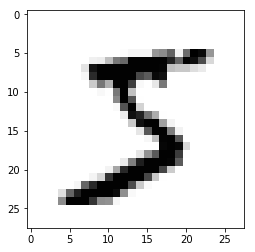

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
X_train.shape,y_train.shape,X_val.shape,X_test.shape,y_test.shape


((50000, 28, 28), (50000,), (10000, 28, 28), (10000, 28, 28), (10000,))

In [3]:
y_train[:10]


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [4]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");
import tensorflow as tf
s = tf.InteractiveSession()
import numpy as np
# access TensorBoard on http://127.0.0.1:7007/


### Lets do a 2 layer Neuralnetwork to solve the problem of identifying digits from 0 to 9

Defining some initializers

In [5]:
def weight_var(shape):
    init = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init)

In [6]:
def bias_var(shape):
    bias = tf.constant( 0.01,shape=shape)
    return tf.Variable(bias)

Reshaping the data for simpler operations

In [7]:
X_t = np.reshape(X_train,(50000, 784))


In [8]:
X_v = np.reshape(X_val,(10000, 784))

In [9]:
X_tes = np.reshape(X_test,(10000, 784))

Defining som placeholders for holding data (in mini batches)

In [10]:
input_X2 = tf.placeholder(tf.float32,shape=[None,784],name="inputx")
input_y2 = tf.placeholder(tf.float32,shape=[None,10],name="inputy")

Defining the weights and activation function

In [11]:
layer1w = weight_var([784,30])
layer1b = bias_var([30])

In [12]:
activ1 = tf.nn.sigmoid(tf.matmul(input_X2,layer1w)+layer1b)

In [13]:
layer2w = weight_var([30,10])
layer2b = bias_var([10])

And the predicted values are...

In [14]:
predicted_y2 = tf.nn.sigmoid(tf.matmul(activ1,layer2w)+layer2b)


And then we need a cost function to train the parameters

In [15]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y2, logits=predicted_y2))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Defining an optimizer for training the weights

In [16]:
optim = tf.train.AdamOptimizer(0.001).minimize(cost,var_list=[layer1w,layer2w])

Running the optimizer and some unfreindly outputdata

In [17]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
batch_size = 1000 # number of examples we use per iteration
itr = 2000 # number of iterations
traincost = []
testcost = []
iterations = []
y_training = tf.one_hot(y_train,10).eval()
y_testing = tf.one_hot(y_test,10).eval()
for i in range(itr):
    ind = np.random.choice(X_t.shape[0], batch_size)
    ind2 = np.random.choice(X_tes.shape[0],X_tes.shape[0])
                            #batch_size)

    s.run(optim, {input_X2: X_t[ind,:], input_y2: y_training[ind]})
    if i%20 == 0:
        traincost.append(s.run(cost, {input_X2: X_t[ind,:], input_y2: y_training[ind]}))
        testcost.append(s.run(cost,{input_X2:X_tes[ind2,:], input_y2: y_testing[ind2]}))
        iterations.append(i)
    if i%300 == 0 or i == itr-1:
        print("loss at iter %i:%.4f" % (i, traincost[len(traincost)-1]))
        print("train auc:", roc_auc_score(y_training[ind], s.run(predicted_y2, {input_X2:X_t[ind,:]})))
        print("test auc:", roc_auc_score(y_testing[ind2], s.run(predicted_y2, {input_X2:X_tes[ind2,:]})))

loss at iter 0:2.3027
train auc: 0.5363627329246097
test auc: 0.5418931915690541
loss at iter 300:1.7984
train auc: 0.9745848173172901
test auc: 0.9725588351276219
loss at iter 600:1.6719
train auc: 0.9872520075553884
test auc: 0.9837077045001266
loss at iter 900:1.6211
train auc: 0.9892797792208666
test auc: 0.986905984435752
loss at iter 1200:1.6017
train auc: 0.9878181381649348
test auc: 0.9891836922350403
loss at iter 1500:1.5681
train auc: 0.9934797218700873
test auc: 0.990118219779254
loss at iter 1800:1.5614
train auc: 0.9912111716959553
test auc: 0.9909160306581359
loss at iter 1999:1.5564
train auc: 0.9918243508011472
test auc: 0.9906758081208702


Lets visualize this beauty!

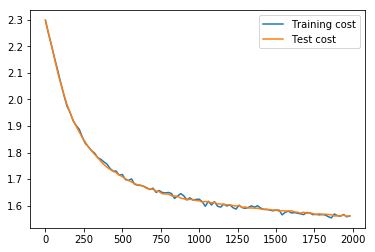

In [143]:
plt.plot(iterations, traincost, label="Training cost")
plt.plot(iterations, testcost, label=r"Test cost")
plt.legend();
plt.show()

Some last minute dataprocessing

In [19]:
y_validation = tf.one_hot(y_val,10).eval()

In [27]:
s.run(predicted_y2, {input_X2:X_v}).sum(1)

array([1.772531 , 1.3336688, 1.139077 , ..., 1.2249432, 1.0789757,
       1.3822646], dtype=float32)

In [145]:
print("And the final model accuracy is ...: %.4f" % 
      (roc_auc_score(y_validation, s.run(predicted_y2, {input_X2:X_v}))))

And the final model accuracy is ...: 0.9911
